In [140]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.stats.diagnostic import acorr_ljungbox

In [141]:
import warnings
warnings.filterwarnings('ignore')

In [142]:
data = pd.read_csv('data/clean/covid_deaths.csv').set_index('date')

## Data exploration

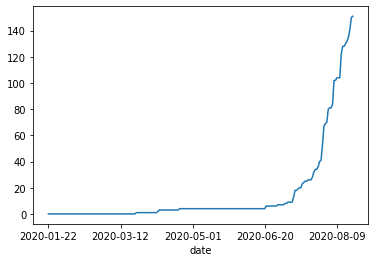

In [143]:
data['T266'].plot()
plt.show()

### Autocorrelation

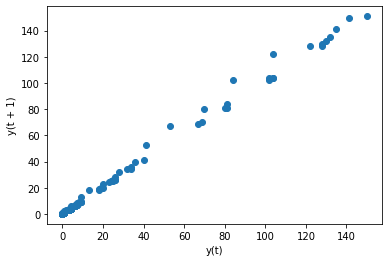

In [144]:
pd.plotting.lag_plot(data['T266'])
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

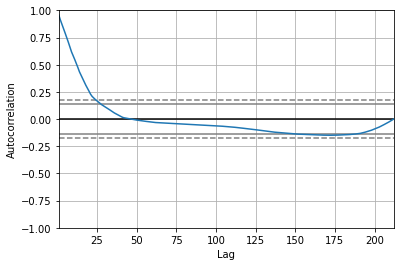

In [145]:
pd.plotting.autocorrelation_plot(data['T266'])

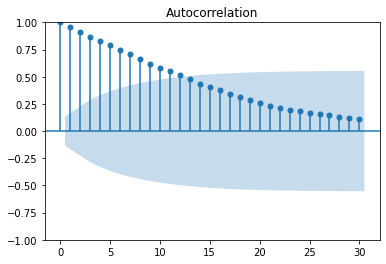

In [146]:
plot_acf(data['T266'], lags=30)
plt.show()

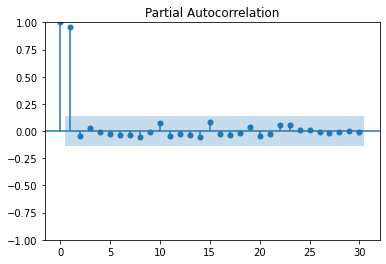

In [147]:
plot_pacf(data['T266'], lags=30, method='ywm')
plt.show()

## Baseline prediction: Dummy model

In [148]:
forecasting_horizon = 5

In [149]:
X = data['T266'].values
train, test = X[1:len(X)-forecasting_horizon], X[len(X)-forecasting_horizon:]

In [150]:
predictions = list()
for x in range(forecasting_horizon):
    predictions.append(train[-1])
test_score = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 198.200


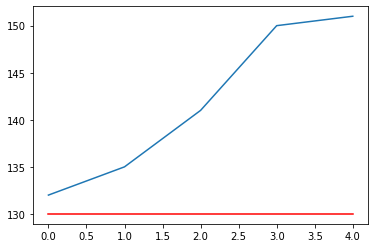

In [151]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Autoregressive model

https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

In [152]:
model = AutoReg(train, lags=10)
model_fit = model.fit()

In [153]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
#for i in range(len(predictions)):
#    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 13.322


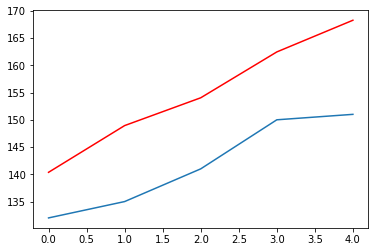

In [154]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Moving average model

https://towardsdatascience.com/moving-averages-in-python-16170e20f6c

In [155]:
predictions = data['T266'].rolling(window=10).mean()[-forecasting_horizon:].values
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 18.587


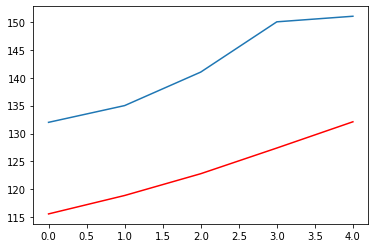

In [156]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Autoregressive moving average model

https://towardsdatascience.com/advanced-time-series-analysis-with-arma-and-arima-a7d9b589ed6d

In [157]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

In [158]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(data['T266'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.5992826713392648
p-value: 0.8711440313917049


In [159]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [160]:
ps = range(0, 8, 1)
d = 0
qs = range(0, 8, 1)
# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=train)
result_df

100%|██████████| 64/64 [00:22<00:00,  2.85it/s]


,"(p, d, q)",AIC
0,"(4, 0, 5)",891.094416
1,"(2, 0, 3)",891.839789
2,"(4, 0, 1)",895.256043
3,"(4, 0, 6)",895.741236
4,"(6, 0, 3)",903.740450
...,...,...
57,"(0, 0, 3)",1354.490050
58,"(0, 0, 4)",1378.238706
59,"(0, 0, 2)",1492.375561
60,"(0, 0, 1)",1719.213446


In [161]:
result_df[result_df['(p, d, q)'] == (4, 0, 0)]

,"(p, d, q)",AIC


In [162]:
result_df['(p, d, q)'][0]

(4, 0, 5)

In [163]:
best_model = SARIMAX(train, order=(4, 0, 0)).fit()
print(best_model.summary())

LinAlgError: LU decomposition error.

In [ ]:
predictions = best_model.forecast(forecasting_horizon)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.298


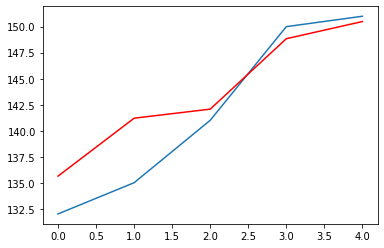

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## TBATS model

https://medium.com/analytics-vidhya/time-series-forecasting-using-tbats-model-ce8c429442a9

In [ ]:
from tbats import BATS, TBATS

In [ ]:
estimator = TBATS()
model = estimator.fit(train)

In [ ]:
predictions = model.forecast(steps=forecasting_horizon)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.098


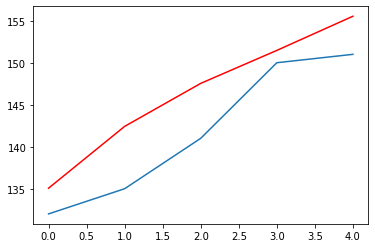

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
print(model.summary())

Use Box-Cox: False
Use trend: True
Use damped trend: False
Seasonal periods: []
Seasonal harmonics []
ARMA errors (p, q): (0, 5)
Smoothing (Alpha): 1.135398
Trend (Beta): 0.115107
Damping Parameter (Phi): 1.000000
Seasonal Parameters (Gamma): []
AR coefficients []
MA coefficients [-0.16675729 -0.24742574  0.10597024  0.08148672  0.26139578]
Seed vector [0.02125554 0.00158486 0.         0.         0.         0.
 0.        ]

AIC 1404.388916
